<a href="https://colab.research.google.com/github/prashantkul/weak-to-strong-gen/blob/main/Prashant_Kulkarni_final_icl_w2s.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Weak-to-Strong Generalization Experiments

**Click the badge above to run this notebook in Google Colab (opens in new tab)!**

---

## Weak-to-Strong Generalization Experiments (Git Version)

This notebook demonstrates how to clone the repository from git and run all experiments.

**What this notebook does:**
- Clones the code repository from GitHub
- Installs all dependencies
- Sets up environment and configuration
- Runs all 6 experiments (baseline, disclaimer, CoT × 2 models)
- Generates comprehensive visualization

**Estimated runtime:** 75-90 minutes total

**Requirements:**
- OpenRouter API key (get from https://openrouter.ai/settings/keys)
- Python 3.10+
- ~$150-200 in API credits (if running all experiments)

---
## Part 1: Repository Setup

This section clones the repository and installs dependencies.

In [1]:
# Cell 1: Clone Repository from GitHub
# This will download all the code from git

import os
from pathlib import Path

# Check if we're in Colab
IN_COLAB = 'COLAB_GPU' in os.environ

if IN_COLAB:
    print("Running in Google Colab")
    # Clone repository to Colab
    !git clone https://github.com/prashantkul/weak-to-strong-gen.git
    %cd weak-to-strong-gen
    REPO_PATH = Path('/content/weak-to-strong-gen')
else:
    print("Running in local Jupyter")
    # For local Jupyter, use current directory
    REPO_PATH = Path.cwd()

print(f"Repository path: {REPO_PATH}")
print(f"Repository exists: {REPO_PATH.exists()}")

Running in Google Colab
Cloning into 'weak-to-strong-gen'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 110 (delta 35), reused 103 (delta 28), pack-reused 0 (from 0)
Receiving objects: 100% (110/110), 1.60 MiB | 9.54 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/weak-to-strong-gen
Repository path: /content/weak-to-strong-gen
Repository exists: True


In [2]:
# Cell 2: Install Dependencies
# This installs all required Python packages

print("Installing dependencies...")
print("This may take 2-3 minutes")
print("="*70)

# Install from requirements.txt
!pip install -q -r /content/weak-to-strong-gen/requirements.txt

print("="*70)
print("✓ Dependencies installed successfully")

Installing dependencies...
This may take 2-3 minutes
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.9/339.9 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.1/296.1 kB 22.3 MB/s eta 0:00:00
✓ Dependencies installed successfully


In [3]:
# Cell 3: Add Repository to Python Path
# This allows us to import the src modules

import sys
from pathlib import Path

# Use absolute path to repository
if IN_COLAB:
    repo_path = '/content/weak-to-strong-gen'
else:
    repo_path = str(Path.cwd())

# Add repository to path if not already there
if repo_path not in sys.path:
    sys.path.insert(0, repo_path)
    print(f"✓ Added {repo_path} to Python path")
else:
    print(f"✓ {repo_path} already in Python path")

# Verify we can import the modules
try:
    from src import Config, DatasetManager, ExperimentRunner
    from notebook_experiments import run_baseline_sweep, run_disclaimer_sweep, run_cot_sweep
    print("✓ Successfully imported all modules")
except ImportError as e:
    print(f"✗ Import failed: {e}")
    print(f"\nCurrent working directory: {Path.cwd()}")
    print(f"Python path: {sys.path[:3]}")
    print("\nTroubleshooting:")
    print("  1. Make sure Cell 1 completed successfully")
    print("  2. Verify you're in the repository directory")
    print("  3. Check that src/ folder exists")

✓ Added /content/weak-to-strong-gen to Python path


/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


✓ Successfully imported all modules


---
## Part 2: Environment Configuration

This section sets up API keys and configuration.

In [4]:
# Cell 4: Set API Keys
# For Google Colab: Use Colab Secrets (RECOMMENDED)

import os

# Check if running in Colab
IN_COLAB = 'COLAB_GPU' in os.environ

if IN_COLAB:
    # COLAB METHOD: Use Secrets
    # 1. Click the key icon (🔑) in the left sidebar
    # 2. Add two secrets:
    #    - Name: OPENROUTER_API_KEY, Value: your primary key
    #    - Name: OPENROUTER_API_KEY_BACKUP, Value: your backup key
    # 3. Enable notebook access for both secrets
    # 4. Run this cell

    from google.colab import userdata
    # Strip whitespace from keys (common copy-paste error)
    os.environ['OPENROUTER_API_KEY'] = userdata.get('OPENROUTER_API_KEY').strip()
    os.environ['OPENROUTER_API_KEY_BACKUP'] = userdata.get('OPENROUTER_API_KEY_BACKUP').strip()
    print("✓ Loaded API keys from Colab Secrets")

else:
    # LOCAL JUPYTER: Use .env file
    from dotenv import load_dotenv
    if load_dotenv():
        # Strip whitespace from keys
        if os.getenv('OPENROUTER_API_KEY'):
            os.environ['OPENROUTER_API_KEY'] = os.getenv('OPENROUTER_API_KEY').strip()
        if os.getenv('OPENROUTER_API_KEY_BACKUP'):
            os.environ['OPENROUTER_API_KEY_BACKUP'] = os.getenv('OPENROUTER_API_KEY_BACKUP').strip()
        print("✓ Loaded API keys from .env file")
    else:
        print("⚠️ No .env file found")
        print("\nTo use locally:")
        print("  1. Copy .env.example to .env")
        print("  2. Edit .env and add your API keys")
        print("  3. Restart kernel and re-run this cell")

# Verify keys are set
if os.getenv('OPENROUTER_API_KEY'):
    key_preview = os.getenv('OPENROUTER_API_KEY')[:15] + "..."
    print(f"✓ Primary API key set: {key_preview}")
else:
    print("✗ OPENROUTER_API_KEY not set!")
    print("\n⚠️ Please set up your API keys before continuing")

✓ Loaded API keys from Colab Secrets
✓ Primary API key set: sk-or-v1-7502a6...


In [5]:
# Cell 5: Initialize Configuration
# Load configuration and set up the environment

from src import Config

# Load configuration from environment variables
config = Config.from_env()
config.setup_environment()

print("="*70)
print("CONFIGURATION")
print("="*70)
print(f"Weak Model:     {config.weak_model}")
print(f"Strong Model:   {config.strong_model}")
print(f"Temperature:    {config.temperature}")
print(f"Max Parallel:   {config.max_parallel_requests}")
print(f"Cache Dir:      {config.cache_dir}")
print("="*70)
print("✓ Configuration loaded successfully")

CONFIGURATION
Weak Model:     meta-llama/llama-3.1-8b-instruct
Strong Model:   meta-llama/llama-3.1-405b-instruct
Temperature:    0.0
Max Parallel:   50
Cache Dir:      cache
✓ Configuration loaded successfully


---
## Part 3: Dataset Loading

Load and verify the TruthfulQA dataset.

In [6]:
# Cell 6: Load Dataset
# This loads the TruthfulQA dataset and splits it into test and few-shot pool

from src import DatasetManager

print("Loading TruthfulQA dataset...")
print("This may take 30-60 seconds on first load")
print("="*70)

dm = DatasetManager()
test_data, few_shot_pool, split = dm.load_split()

print("="*70)
print("DATASET LOADED")
print("="*70)
print(f"Test Set Size:      {len(test_data)} questions")
print(f"Few-Shot Pool Size: {len(few_shot_pool)} questions")
print(f"Split Used:         {split}")
print("="*70)

# Show example question
print("\nExample Question:")
print(test_data[0].question)
print(f"\nCorrect Answer: {test_data[0].answer}")
print("\n✓ Dataset loaded successfully")

Loading TruthfulQA dataset...
This may take 30-60 seconds on first load

Loading saved dataset split...
  ✓ Loaded 200 test, 100 few-shot pool
  Seed: 42, Dataset: truthfulqa
DATASET LOADED
Test Set Size:      200 questions
Few-Shot Pool Size: 100 questions
Split Used:         train_ids=[147, 446, 360, 659, 155, 607, 327, 201, 467, 88, 396, 152, 658, 584, 430, 148, 45, 294, 381, 427, 626, 137, 215, 564, 355, 130, 164, 425, 450, 197, 17, 221, 461, 416, 102, 468, 168, 655, 286, 58, 590, 543, 335, 78, 674, 496, 235, 209, 339, 56, 460, 219, 9, 668, 398, 514, 624, 136, 383, 494, 477, 91, 12, 211, 90, 83, 424, 312, 422, 465, 52, 437, 308, 183, 366, 186, 157, 21, 567, 466, 75, 329, 18, 279, 76, 436, 601, 321, 287, 218, 282, 435, 82, 134, 66, 170, 414, 22, 576, 407, 426, 26, 525, 609, 258, 316, 406, 611, 107, 309, 144, 139, 399, 320, 54, 531, 457, 68, 53, 347, 583, 349, 640, 313, 154, 278, 577, 633, 145, 189, 125, 377, 178, 350, 642, 259, 419, 275, 458, 51, 288, 318, 346, 4, 37, 358, 600, 153,

In [7]:
# Cell 7: Quick Test (Optional)
# Run a quick test to verify everything is working
# This will make one API call to test the setup

from test_notebook_functions import test_notebook_setup

print("Running quick test...")
print("This will make one API call to verify the setup")
print("="*70)

test_passed = await test_notebook_setup()

if test_passed:
    print("\n" + "="*70)
    print("✓ ALL TESTS PASSED")
    print("✓ Ready to run experiments!")
    print("="*70)
else:
    print("\n" + "="*70)
    print("✗ TESTS FAILED")
    print("Please check the errors above and fix them before proceeding")
    print("="*70)

Running quick test...
This will make one API call to verify the setup
Testing notebook experiment functions...
✓ Notebook functions imported successfully
✓ Source modules imported successfully
✓ Config loaded successfully
  - Weak model: meta-llama/llama-3.1-8b-instruct
  - Strong model: meta-llama/llama-3.1-405b-instruct

Loading saved dataset split...
  ✓ Loaded 200 test, 100 few-shot pool
  Seed: 42, Dataset: truthfulqa
✓ Dataset loaded successfully
  - Test set: 200 questions
  - Few-shot pool: 100 questions
cache_dir=PosixPath('cache'), use_redis=False, num_bins=20
self.cache_manager=<safetytooling.apis.inference.cache_manager.FileBasedCacheManager object at 0x7b18f619b4d0>
✓ API call successful
  - Question ID: 264
  - Answer: B
  - Model: meta-llama/llama-3.1-8b-instruct

✓ ALL TESTS PASSED - Ready to run experiments!

✓ ALL TESTS PASSED
✓ Ready to run experiments!


---
## Part 4: Baseline Experiments

Run baseline experiments for both model pairs (8B→405B and 8B→70B) across K∈{0,2,5,10}.

In [8]:
# Cell 8: Run 405B Baseline Experiments
# Tests how 405B performs with weak supervision at different K values
# Expected runtime: 15-20 minutes

from notebook_experiments import run_baseline_sweep

print("="*70)
print("EXPERIMENT 1: 405B BASELINE")
print("="*70)
print("Testing 8B→405B with K={0,2,5,10}")
print("Expected runtime: 15-20 minutes")
print("="*70)

results_405b_baseline = await run_baseline_sweep(
    model_pair="8b_to_405b",
    k_values=[0, 2, 5, 10],
    save_results=True
)

print("\n" + "="*70)
print("✓ 405B BASELINE COMPLETE")
print("="*70)
print("\nResults Summary:")
for k, result in results_405b_baseline['pgr_results'].items():
    print(f"  K={k}: PGR = {result.pgr:.3f} ({result.pgr_percentage})")
print("="*70)

EXPERIMENT 1: 405B BASELINE
Testing 8B→405B with K={0,2,5,10}
Expected runtime: 15-20 minutes

BASELINE EXPERIMENT: 8B_TO_405B

Weak Model:  meta-llama/llama-3.1-8b-instruct
Strong Model: meta-llama/llama-3.1-405b-instruct
K values: [0, 2, 5, 10]

Loading saved dataset split...
  ✓ Loaded 200 test, 100 few-shot pool
  Seed: 42, Dataset: truthfulqa

✓ Test set: 200 questions
✓ Few-shot pool: 100 questions
cache_dir=PosixPath('cache'), use_redis=False, num_bins=20
self.cache_manager=<safetytooling.apis.inference.cache_manager.FileBasedCacheManager object at 0x7b18f619b4d0>

GENERATING WEAK LABELS

Evaluating 10 questions with llama-3.1-8b-instruct...
Running in parallel (max 50 concurrent)...
  Progress: 10/10 (100%) | Rate: 6.7 q/s | ETA: 0.0 min
✓ Completed 10 evaluations in 0.0 minutes (avg 0.1s per question)
✓ Generated 10 weak labels

K = 0

Running baseline: weak_k0
Model: meta-llama/llama-3.1-8b-instruct

Evaluating 200 questions with llama-3.1-8b-instruct...
Running in parallel (

  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)
  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 10/200 (5%) | Rate: 13.1 q/s | ETA: 0.2 min
  Progress: 20/200 (10%) | Rate: 21.7 q/s | ETA: 0.1 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 30/200 (15%) | Rate: 25.1 q/s | ETA: 0.1 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 40/200 (20%) | Rate: 26.2 q/s | ETA: 0.1 min
  Progress: 50/200 (25%) | Rate: 23.5 q/s | ETA: 0.1 min
  Progress: 60/200 (30%) | Rate: 18.5 q/s | ETA: 0.1 min
  Progress: 70/200 (35%) | Rate: 16.7 q/s | ETA: 0.1 min
  Progress: 80/200 (40%) | Rate: 16.0 q/s | ETA: 0.1 min
  Progress: 90/200 (45%) | Rate: 17.8 q/s | ETA: 0.1 min
  Progress: 100/200 (50%) | Rate: 19.5 q/s | ETA: 0.1 min
  Progress: 110/200 (55%) | Rate: 21.2 q/s | ETA: 0.1 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 120/200 (60%) | Rate: 21.8 q/s | ETA: 0.1 min
  Progress: 130/200 (65%) | Rate: 23.1 q/s | ETA: 0.1 min
  Progress: 140/200 (70%) | Rate: 24.7 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 150/200 (75%) | Rate: 25.3 q/s | ETA: 0.0 min
  Progress: 160/200 (80%) | Rate: 26.4 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 170/200 (85%) | Rate: 23.8 q/s | ETA: 0.0 min
  Progress: 180/200 (90%) | Rate: 24.1 q/s | ETA: 0.0 min
  Progress: 190/200 (95%) | Rate: 24.0 q/s | ETA: 0.0 min
  Progress: 200/200 (100%) | Rate: 24.4 q/s | ETA: 0.0 min
✓ Completed 200 evaluations in 0.1 minutes (avg 0.0s per question)

✓ Accuracy: 86.50% (173/200)

K=0 Results:

Performance Gap Recovered (PGR) Metrics:
Weak Model Baseline:      58.50%
Strong Model (Gold):      86.50%
Strong Model (Weak):      86.50%

Performance Gap:          28.00%
Recovered Gap:            28.00%
PGR:                      1.000 (100.0%)


K = 2

Running experiment: strong_gold_k2
Model: meta-llama/llama-3.1-405b-instruct
Few-shot: 2 examples (gold labels)

Evaluating 200 questions with llama-3.1-405b-instruct...
Running in parallel (max 50 concurrent)...
  Progress: 10/200 (5%) | Rate: 15.2 q/s | ETA: 0.2 min
  Progress: 20/200 (10%) | Rate: 24.5 q/s | ETA: 0.1 min
  Progress: 30/200 (15%) | Rate: 33.7 q/s | ETA: 0.1 min
  Progress: 40/

  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 70/200 (35%) | Rate: 46.8 q/s | ETA: 0.0 min
  Progress: 80/200 (40%) | Rate: 50.2 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 90/200 (45%) | Rate: 52.8 q/s | ETA: 0.0 min
  Progress: 100/200 (50%) | Rate: 54.2 q/s | ETA: 0.0 min
  Progress: 110/200 (55%) | Rate: 54.6 q/s | ETA: 0.0 min
  Progress: 120/200 (60%) | Rate: 57.0 q/s | ETA: 0.0 min
  Progress: 130/200 (65%) | Rate: 58.3 q/s | ETA: 0.0 min
  Progress: 140/200 (70%) | Rate: 58.0 q/s | ETA: 0.0 min
  Progress: 150/200 (75%) | Rate: 59.3 q/s | ETA: 0.0 min
  Progress: 160/200 (80%) | Rate: 59.3 q/s | ETA: 0.0 min
  Progress: 170/200 (85%) | Rate: 57.7 q/s | ETA: 0.0 min
  Progress: 180/200 (90%) | Rate: 57.3 q/s | ETA: 0.0 min
  Progress: 190/200 (95%) | Rate: 57.1 q/s | ETA: 0.0 min
  Progress: 200/200 (100%) | Rate: 46.2 q/s | ETA: 0.0 min
✓ Completed 200 evaluations in 0.1 minutes (avg 0.0s per question)

✓ Accuracy: 89.00% (178/200)

Running experiment: strong_weak_k2
Model: meta-llama/llama-3.1-405b-instruct
Few-shot: 2 examples (weak labels)

Evaluating 200 questions with llama-3.1-405b-instruct...
Running in parallel (max 50 concurre

  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 90/200 (45%) | Rate: 23.9 q/s | ETA: 0.1 min
  Progress: 100/200 (50%) | Rate: 21.2 q/s | ETA: 0.1 min
  Progress: 110/200 (55%) | Rate: 19.9 q/s | ETA: 0.1 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)
  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 120/200 (60%) | Rate: 19.9 q/s | ETA: 0.1 min
  Progress: 130/200 (65%) | Rate: 20.9 q/s | ETA: 0.1 min
  Progress: 140/200 (70%) | Rate: 22.1 q/s | ETA: 0.0 min
  Progress: 150/200 (75%) | Rate: 23.1 q/s | ETA: 0.0 min
  Progress: 160/200 (80%) | Rate: 23.8 q/s | ETA: 0.0 min
  Progress: 170/200 (85%) | Rate: 24.3 q/s | ETA: 0.0 min
  Progress: 180/200 (90%) | Rate: 23.0 q/s | ETA: 0.0 min
  Progress: 190/200 (95%) | Rate: 16.0 q/s | ETA: 0.0 min
  Progress: 200/200 (100%) | Rate: 14.8 q/s | ETA: 0.0 min
✓ Completed 200 evaluations in 0.2 minutes (avg 0.1s per question)

✓ Accuracy: 84.00% (168/200)

K=2 Results:

Performance Gap Recovered (PGR) Metrics:
Weak Model Baseline:      58.50%
Strong Model (Gold):      89.00%
Strong Model (Weak):      84.00%

Performance Gap:          30.50%
Recovered Gap:            25.50%
PGR:                      0.836 (83.6%)


K = 5

Running experiment: strong_gold_k5
Model: meta-llama/llama-3.1-405b-instruct
Few-shot: 5 examples (gold label

  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)
  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 90/200 (45%) | Rate: 34.6 q/s | ETA: 0.1 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 100/200 (50%) | Rate: 35.6 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 110/200 (55%) | Rate: 35.0 q/s | ETA: 0.0 min
  Progress: 120/200 (60%) | Rate: 34.7 q/s | ETA: 0.0 min
  Progress: 130/200 (65%) | Rate: 33.9 q/s | ETA: 0.0 min
  Progress: 140/200 (70%) | Rate: 33.5 q/s | ETA: 0.0 min
  Progress: 150/200 (75%) | Rate: 34.2 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 160/200 (80%) | Rate: 34.0 q/s | ETA: 0.0 min
  Progress: 170/200 (85%) | Rate: 24.3 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 180/200 (90%) | Rate: 23.2 q/s | ETA: 0.0 min
  Progress: 190/200 (95%) | Rate: 23.6 q/s | ETA: 0.0 min
  Progress: 200/200 (100%) | Rate: 9.3 q/s | ETA: 0.0 min
✓ Completed 200 evaluations in 0.4 minutes (avg 0.1s per question)

✓ Accuracy: 89.50% (179/200)

Running experiment: strong_weak_k5
Model: meta-llama/llama-3.1-405b-instruct
Few-shot: 5 examples (weak labels)

Evaluating 200 questions with llama-3.1-405b-instruct...
Running in parallel (max 50 concurrent)...


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)
  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 10/200 (5%) | Rate: 10.1 q/s | ETA: 0.3 min
  Progress: 20/200 (10%) | Rate: 18.9 q/s | ETA: 0.2 min
  Progress: 30/200 (15%) | Rate: 25.6 q/s | ETA: 0.1 min
  Progress: 40/200 (20%) | Rate: 29.7 q/s | ETA: 0.1 min
  Progress: 50/200 (25%) | Rate: 32.7 q/s | ETA: 0.1 min
  Progress: 60/200 (30%) | Rate: 36.3 q/s | ETA: 0.1 min
  Progress: 70/200 (35%) | Rate: 39.4 q/s | ETA: 0.1 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 80/200 (40%) | Rate: 41.8 q/s | ETA: 0.0 min
  Progress: 90/200 (45%) | Rate: 43.5 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 100/200 (50%) | Rate: 44.2 q/s | ETA: 0.0 min
  Progress: 110/200 (55%) | Rate: 45.1 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 120/200 (60%) | Rate: 45.3 q/s | ETA: 0.0 min
  Progress: 130/200 (65%) | Rate: 46.2 q/s | ETA: 0.0 min
  Progress: 140/200 (70%) | Rate: 47.5 q/s | ETA: 0.0 min
  Progress: 150/200 (75%) | Rate: 46.5 q/s | ETA: 0.0 min
  Progress: 160/200 (80%) | Rate: 44.0 q/s | ETA: 0.0 min
  Progress: 170/200 (85%) | Rate: 44.4 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)
  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 180/200 (90%) | Rate: 44.7 q/s | ETA: 0.0 min
  Progress: 190/200 (95%) | Rate: 46.1 q/s | ETA: 0.0 min
  Progress: 200/200 (100%) | Rate: 37.2 q/s | ETA: 0.0 min
✓ Completed 200 evaluations in 0.1 minutes (avg 0.0s per question)

✓ Accuracy: 88.50% (177/200)

K=5 Results:

Performance Gap Recovered (PGR) Metrics:
Weak Model Baseline:      58.50%
Strong Model (Gold):      89.50%
Strong Model (Weak):      88.50%

Performance Gap:          31.00%
Recovered Gap:            30.00%
PGR:                      0.968 (96.8%)


K = 10

Running experiment: strong_gold_k10
Model: meta-llama/llama-3.1-405b-instruct
Few-shot: 10 examples (gold labels)

Evaluating 200 questions with llama-3.1-405b-instruct...
Running in parallel (max 50 concurrent)...


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 10/200 (5%) | Rate: 10.1 q/s | ETA: 0.3 min
  Progress: 20/200 (10%) | Rate: 17.7 q/s | ETA: 0.2 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 30/200 (15%) | Rate: 22.7 q/s | ETA: 0.1 min
  Progress: 40/200 (20%) | Rate: 27.0 q/s | ETA: 0.1 min
  Progress: 50/200 (25%) | Rate: 30.5 q/s | ETA: 0.1 min
  Progress: 60/200 (30%) | Rate: 33.8 q/s | ETA: 0.1 min
  Progress: 70/200 (35%) | Rate: 36.2 q/s | ETA: 0.1 min
  Progress: 80/200 (40%) | Rate: 38.5 q/s | ETA: 0.1 min
  Progress: 90/200 (45%) | Rate: 40.6 q/s | ETA: 0.0 min
  Progress: 100/200 (50%) | Rate: 42.5 q/s | ETA: 0.0 min
  Progress: 110/200 (55%) | Rate: 43.9 q/s | ETA: 0.0 min
  Progress: 120/200 (60%) | Rate: 45.3 q/s | ETA: 0.0 min
  Progress: 130/200 (65%) | Rate: 46.4 q/s | ETA: 0.0 min
  Progress: 140/200 (70%) | Rate: 47.3 q/s | ETA: 0.0 min
  Progress: 150/200 (75%) | Rate: 48.2 q/s | ETA: 0.0 min
  Progress: 160/200 (80%) | Rate: 49.5 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 170/200 (85%) | Rate: 49.8 q/s | ETA: 0.0 min
  Progress: 180/200 (90%) | Rate: 50.5 q/s | ETA: 0.0 min
  Progress: 190/200 (95%) | Rate: 47.9 q/s | ETA: 0.0 min
  Progress: 200/200 (100%) | Rate: 28.5 q/s | ETA: 0.0 min
✓ Completed 200 evaluations in 0.1 minutes (avg 0.0s per question)

✓ Accuracy: 90.00% (180/200)

Running experiment: strong_weak_k10
Model: meta-llama/llama-3.1-405b-instruct
Few-shot: 10 examples (weak labels)

Evaluating 200 questions with llama-3.1-405b-instruct...
Running in parallel (max 50 concurrent)...
  Progress: 10/200 (5%) | Rate: 9.9 q/s | ETA: 0.3 min
  Progress: 20/200 (10%) | Rate: 15.9 q/s | ETA: 0.2 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 30/200 (15%) | Rate: 18.1 q/s | ETA: 0.2 min
  Progress: 40/200 (20%) | Rate: 14.1 q/s | ETA: 0.2 min
  Progress: 50/200 (25%) | Rate: 13.1 q/s | ETA: 0.2 min
  Progress: 60/200 (30%) | Rate: 12.2 q/s | ETA: 0.2 min
  Progress: 70/200 (35%) | Rate: 13.2 q/s | ETA: 0.2 min
  Progress: 80/200 (40%) | Rate: 14.6 q/s | ETA: 0.1 min
  Progress: 90/200 (45%) | Rate: 15.7 q/s | ETA: 0.1 min
  Progress: 100/200 (50%) | Rate: 17.0 q/s | ETA: 0.1 min
  Progress: 110/200 (55%) | Rate: 18.2 q/s | ETA: 0.1 min
  Progress: 120/200 (60%) | Rate: 19.3 q/s | ETA: 0.1 min
  Progress: 130/200 (65%) | Rate: 20.3 q/s | ETA: 0.1 min
  Progress: 140/200 (70%) | Rate: 21.2 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 150/200 (75%) | Rate: 22.3 q/s | ETA: 0.0 min
  Progress: 160/200 (80%) | Rate: 23.2 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 170/200 (85%) | Rate: 23.9 q/s | ETA: 0.0 min
  Progress: 180/200 (90%) | Rate: 24.9 q/s | ETA: 0.0 min
  Progress: 190/200 (95%) | Rate: 25.3 q/s | ETA: 0.0 min
  Progress: 200/200 (100%) | Rate: 22.0 q/s | ETA: 0.0 min
✓ Completed 200 evaluations in 0.2 minutes (avg 0.0s per question)

✓ Accuracy: 89.50% (179/200)

K=10 Results:

Performance Gap Recovered (PGR) Metrics:
Weak Model Baseline:      58.50%
Strong Model (Gold):      90.00%
Strong Model (Weak):      89.50%

Performance Gap:          31.50%
Recovered Gap:            31.00%
PGR:                      0.984 (98.4%)


Saving experiment results to results/8b_405b_baseline_20251102_235952/
  ✓ Saved experiment.json
  ✓ Saved summary.txt

✓ Results saved to: results/8b_405b_baseline_20251102_235952/

✓ 405B BASELINE COMPLETE

Results Summary:
  K=0: PGR = 1.000 (100.0%)
  K=2: PGR = 0.836 (83.6%)
  K=5: PGR = 0.968 (96.8%)
  K=10: PGR = 0.984 (98.4%)


In [9]:
# Cell 9: Run 70B Baseline Experiments
# Tests how 70B performs with weak supervision at different K values
# Expected runtime: 10-15 minutes

print("="*70)
print("EXPERIMENT 2: 70B BASELINE")
print("="*70)
print("Testing 8B→70B with K={0,2,5,10}")
print("Expected runtime: 10-15 minutes")
print("="*70)

results_70b_baseline = await run_baseline_sweep(
    model_pair="8b_to_70b",
    k_values=[0, 2, 5, 10],
    save_results=True
)

print("\n" + "="*70)
print("✓ 70B BASELINE COMPLETE")
print("="*70)
print("\nResults Summary:")
for k, result in results_70b_baseline['pgr_results'].items():
    print(f"  K={k}: PGR = {result.pgr:.3f} ({result.pgr_percentage})")
print("="*70)

# Compare the two models
print("\nComparison at K=10:")
pgr_405b = results_405b_baseline['pgr_results'][10].pgr
pgr_70b = results_70b_baseline['pgr_results'][10].pgr
print(f"  405B: {pgr_405b:.3f} ({pgr_405b*100:.1f}%)")
print(f"  70B:  {pgr_70b:.3f} ({pgr_70b*100:.1f}%)")
print(f"  Gap:  {(pgr_405b - pgr_70b)*100:.1f} percentage points")

EXPERIMENT 2: 70B BASELINE
Testing 8B→70B with K={0,2,5,10}
Expected runtime: 10-15 minutes

BASELINE EXPERIMENT: 8B_TO_70B

Weak Model:  meta-llama/llama-3.1-8b-instruct
Strong Model: meta-llama/llama-3.1-70b-instruct
K values: [0, 2, 5, 10]

Loading saved dataset split...
  ✓ Loaded 200 test, 100 few-shot pool
  Seed: 42, Dataset: truthfulqa

✓ Test set: 200 questions
✓ Few-shot pool: 100 questions
cache_dir=PosixPath('cache'), use_redis=False, num_bins=20
self.cache_manager=<safetytooling.apis.inference.cache_manager.FileBasedCacheManager object at 0x7b17c75376b0>

GENERATING WEAK LABELS

Evaluating 10 questions with llama-3.1-8b-instruct...
Running in parallel (max 50 concurrent)...
  Progress: 10/10 (100%) | Rate: 1351.5 q/s | ETA: 0.0 min
✓ Completed 10 evaluations in 0.0 minutes (avg 0.0s per question)
✓ Generated 10 weak labels

K = 0

Running baseline: weak_k0
Model: meta-llama/llama-3.1-8b-instruct

Evaluating 200 questions with llama-3.1-8b-instruct...
Running in parallel (m

  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-70b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 160/200 (80%) | Rate: 64.4 q/s | ETA: 0.0 min
  Progress: 170/200 (85%) | Rate: 67.0 q/s | ETA: 0.0 min
  Progress: 180/200 (90%) | Rate: 69.5 q/s | ETA: 0.0 min
  Progress: 190/200 (95%) | Rate: 68.6 q/s | ETA: 0.0 min
  Progress: 200/200 (100%) | Rate: 38.0 q/s | ETA: 0.0 min
✓ Completed 200 evaluations in 0.1 minutes (avg 0.0s per question)

✓ Accuracy: 86.50% (173/200)

Running experiment: strong_weak_k5
Model: meta-llama/llama-3.1-70b-instruct
Few-shot: 5 examples (weak labels)

Evaluating 200 questions with llama-3.1-70b-instruct...
Running in parallel (max 50 concurrent)...
  Progress: 10/200 (5%) | Rate: 13.5 q/s | ETA: 0.2 min
  Progress: 20/200 (10%) | Rate: 22.5 q/s | ETA: 0.1 min
  Progress: 30/200 (15%) | Rate: 30.6 q/s | ETA: 0.1 min
  Progress: 40/200 (20%) | Rate: 33.9 q/s | ETA: 0.1 min
  Progress: 50/200 (25%) | Rate: 37.2 q/s | ETA: 0.1 min
  Progress: 60/200 (30%) | Rate: 37.6 q/s | ETA: 0.1 min
  Progress: 70/200 (35%) | Rate: 39.7 q/s | ETA: 0.1 min
  

---
## Part 5: Disclaimer Experiments

Run disclaimer experiments that add a metacognitive warning about weak label quality.

In [10]:
# Cell 10: Run 405B Disclaimer Experiments
# Tests if warning about weak labels helps 405B
# Expected runtime: 10 minutes

from notebook_experiments import run_disclaimer_sweep

print("="*70)
print("EXPERIMENT 3: 405B DISCLAIMER")
print("="*70)
print("Testing metacognitive prompt for 405B")
print("Expected runtime: 10 minutes")
print("="*70)

# Find the baseline experiment path
baseline_405b_path = results_405b_baseline['experiment_path']
print(f"Using baseline from: {baseline_405b_path}\n")

results_405b_disclaimer = await run_disclaimer_sweep(
    model_pair="8b_to_405b",
    k_values=[0, 2, 5, 10],
    baseline_exp_path=baseline_405b_path,
    save_results=True
)

print("\n" + "="*70)
print("✓ 405B DISCLAIMER COMPLETE")
print("="*70)
print("\nResults Summary (Delta from Baseline):")
for k, result in results_405b_disclaimer['pgr_results'].items():
    baseline_pgr = results_405b_baseline['pgr_results'][k].pgr
    delta = result.pgr - baseline_pgr
    sign = "+" if delta >= 0 else ""
    print(f"  K={k}: PGR = {result.pgr:.3f} (Δ = {sign}{delta:.3f})")
print("="*70)

EXPERIMENT 3: 405B DISCLAIMER
Testing metacognitive prompt for 405B
Expected runtime: 10 minutes
Using baseline from: results/8b_405b_baseline_20251102_235952/experiment.json


DISCLAIMER EXPERIMENT: 8B_TO_405B

Weak Model:  meta-llama/llama-3.1-8b-instruct
Strong Model: meta-llama/llama-3.1-405b-instruct
Disclaimer: ENABLED

Loading saved dataset split...
  ✓ Loaded 200 test, 100 few-shot pool
  Seed: 42, Dataset: truthfulqa

Loading baseline from: results/8b_405b_baseline_20251102_235952/experiment.json
✓ Loaded baseline PGR metrics
✓ Loaded 10 weak labels
cache_dir=PosixPath('cache'), use_redis=False, num_bins=20
self.cache_manager=<safetytooling.apis.inference.cache_manager.FileBasedCacheManager object at 0x7b17c67ae270>

K = 0

Running baseline: strong_disclaimer_k0
Model: meta-llama/llama-3.1-405b-instruct

Evaluating 200 questions with llama-3.1-405b-instruct...
Running in parallel (max 50 concurrent)...


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 10/200 (5%) | Rate: 11.2 q/s | ETA: 0.3 min
  Progress: 20/200 (10%) | Rate: 20.1 q/s | ETA: 0.1 min
  Progress: 30/200 (15%) | Rate: 22.4 q/s | ETA: 0.1 min
  Progress: 40/200 (20%) | Rate: 25.0 q/s | ETA: 0.1 min
  Progress: 50/200 (25%) | Rate: 26.6 q/s | ETA: 0.1 min
  Progress: 60/200 (30%) | Rate: 29.1 q/s | ETA: 0.1 min
  Progress: 70/200 (35%) | Rate: 31.6 q/s | ETA: 0.1 min
  Progress: 80/200 (40%) | Rate: 33.9 q/s | ETA: 0.1 min
  Progress: 90/200 (45%) | Rate: 34.7 q/s | ETA: 0.1 min
  Progress: 100/200 (50%) | Rate: 34.8 q/s | ETA: 0.0 min
  Progress: 110/200 (55%) | Rate: 37.5 q/s | ETA: 0.0 min
  Progress: 120/200 (60%) | Rate: 39.0 q/s | ETA: 0.0 min
  Progress: 130/200 (65%) | Rate: 41.4 q/s | ETA: 0.0 min
  Progress: 140/200 (70%) | Rate: 42.8 q/s | ETA: 0.0 min
  Progress: 150/200 (75%) | Rate: 43.3 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 160/200 (80%) | Rate: 41.6 q/s | ETA: 0.0 min
  Progress: 170/200 (85%) | Rate: 43.0 q/s | ETA: 0.0 min
  Progress: 180/200 (90%) | Rate: 44.6 q/s | ETA: 0.0 min
  Progress: 190/200 (95%) | Rate: 46.3 q/s | ETA: 0.0 min
  Progress: 200/200 (100%) | Rate: 31.8 q/s | ETA: 0.0 min
✓ Completed 200 evaluations in 0.1 minutes (avg 0.0s per question)

✓ Accuracy: 84.00% (168/200)

K=0 Comparison:
  Baseline PGR:   1.000
  Disclaimer PGR: 0.911
  Change:         -0.089

K = 2

Running experiment: strong_weak_disclaimer_k2
Model: meta-llama/llama-3.1-405b-instruct
Few-shot: 2 examples (weak labels)

Evaluating 200 questions with llama-3.1-405b-instruct...
Running in parallel (max 50 concurrent)...
  Progress: 10/200 (5%) | Rate: 9.2 q/s | ETA: 0.3 min
  Progress: 20/200 (10%) | Rate: 15.2 q/s | ETA: 0.2 min
  Progress: 30/200 (15%) | Rate: 19.1 q/s | ETA: 0.1 min
  Progress: 40/200 (20%) | Rate: 23.2 q/s | ETA: 0.1 min
  Progress: 50/200 (25%) | Rate: 25.2 q/s | ETA: 0.1 min
  Progr

  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 190/200 (95%) | Rate: 40.0 q/s | ETA: 0.0 min
  Progress: 200/200 (100%) | Rate: 33.8 q/s | ETA: 0.0 min
✓ Completed 200 evaluations in 0.1 minutes (avg 0.0s per question)

✓ Accuracy: 88.50% (177/200)

K=2 Comparison:
  Baseline PGR:   0.836
  Disclaimer PGR: 0.984
  Change:         +0.148

K = 5

Running experiment: strong_weak_disclaimer_k5
Model: meta-llama/llama-3.1-405b-instruct
Few-shot: 5 examples (weak labels)

Evaluating 200 questions with llama-3.1-405b-instruct...
Running in parallel (max 50 concurrent)...
  Progress: 10/200 (5%) | Rate: 10.7 q/s | ETA: 0.3 min
  Progress: 20/200 (10%) | Rate: 18.3 q/s | ETA: 0.2 min
  Progress: 30/200 (15%) | Rate: 24.3 q/s | ETA: 0.1 min
  Progress: 40/200 (20%) | Rate: 28.4 q/s | ETA: 0.1 min
  Progress: 50/200 (25%) | Rate: 29.6 q/s | ETA: 0.1 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 60/200 (30%) | Rate: 29.8 q/s | ETA: 0.1 min
  Progress: 70/200 (35%) | Rate: 29.0 q/s | ETA: 0.1 min
  Progress: 80/200 (40%) | Rate: 25.6 q/s | ETA: 0.1 min
  Progress: 90/200 (45%) | Rate: 22.7 q/s | ETA: 0.1 min
  Progress: 100/200 (50%) | Rate: 17.4 q/s | ETA: 0.1 min
  Progress: 110/200 (55%) | Rate: 16.2 q/s | ETA: 0.1 min
  Progress: 120/200 (60%) | Rate: 17.2 q/s | ETA: 0.1 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 130/200 (65%) | Rate: 17.7 q/s | ETA: 0.1 min
  Progress: 140/200 (70%) | Rate: 18.5 q/s | ETA: 0.1 min
  Progress: 150/200 (75%) | Rate: 19.0 q/s | ETA: 0.0 min
  Progress: 160/200 (80%) | Rate: 19.8 q/s | ETA: 0.0 min
  Progress: 170/200 (85%) | Rate: 16.9 q/s | ETA: 0.0 min
  Progress: 180/200 (90%) | Rate: 15.6 q/s | ETA: 0.0 min
  Progress: 190/200 (95%) | Rate: 16.0 q/s | ETA: 0.0 min
  Progress: 200/200 (100%) | Rate: 16.2 q/s | ETA: 0.0 min
✓ Completed 200 evaluations in 0.2 minutes (avg 0.1s per question)

✓ Accuracy: 90.00% (180/200)

K=5 Comparison:
  Baseline PGR:   0.968
  Disclaimer PGR: 1.016
  Change:         +0.048

K = 10

Running experiment: strong_weak_disclaimer_k10
Model: meta-llama/llama-3.1-405b-instruct
Few-shot: 10 examples (weak labels)

Evaluating 200 questions with llama-3.1-405b-instruct...
Running in parallel (max 50 concurrent)...


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 10/200 (5%) | Rate: 8.1 q/s | ETA: 0.4 min
  Progress: 20/200 (10%) | Rate: 14.3 q/s | ETA: 0.2 min
  Progress: 30/200 (15%) | Rate: 16.0 q/s | ETA: 0.2 min
  Progress: 40/200 (20%) | Rate: 18.5 q/s | ETA: 0.1 min
  Progress: 50/200 (25%) | Rate: 20.5 q/s | ETA: 0.1 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 60/200 (30%) | Rate: 22.3 q/s | ETA: 0.1 min
  Progress: 70/200 (35%) | Rate: 24.3 q/s | ETA: 0.1 min
  Progress: 80/200 (40%) | Rate: 25.5 q/s | ETA: 0.1 min
  Progress: 90/200 (45%) | Rate: 26.8 q/s | ETA: 0.1 min
  Progress: 100/200 (50%) | Rate: 28.1 q/s | ETA: 0.1 min
  Progress: 110/200 (55%) | Rate: 29.5 q/s | ETA: 0.1 min
  Progress: 120/200 (60%) | Rate: 30.5 q/s | ETA: 0.0 min
  Progress: 130/200 (65%) | Rate: 31.6 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 140/200 (70%) | Rate: 31.3 q/s | ETA: 0.0 min
  Progress: 150/200 (75%) | Rate: 31.2 q/s | ETA: 0.0 min
  Progress: 160/200 (80%) | Rate: 32.2 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 170/200 (85%) | Rate: 31.4 q/s | ETA: 0.0 min
  Progress: 180/200 (90%) | Rate: 31.3 q/s | ETA: 0.0 min
  Progress: 190/200 (95%) | Rate: 30.7 q/s | ETA: 0.0 min
  Progress: 200/200 (100%) | Rate: 29.7 q/s | ETA: 0.0 min
✓ Completed 200 evaluations in 0.1 minutes (avg 0.0s per question)

✓ Accuracy: 88.00% (176/200)

K=10 Comparison:
  Baseline PGR:   0.984
  Disclaimer PGR: 0.937
  Change:         -0.048

Saving experiment results to results/8b_405b_disclaimer_20251103_001100/
  ✓ Saved experiment.json
  ✓ Saved summary.txt

✓ Results saved to: results/8b_405b_disclaimer_20251103_001100/

✓ 405B DISCLAIMER COMPLETE

Results Summary (Delta from Baseline):
  K=0: PGR = 0.911 (Δ = -0.089)
  K=2: PGR = 0.984 (Δ = +0.148)
  K=5: PGR = 1.016 (Δ = +0.048)
  K=10: PGR = 0.937 (Δ = -0.048)


In [11]:
# Cell 11: Run 70B Disclaimer Experiments
# Tests if warning about weak labels helps 70B
# Expected runtime: 8 minutes

print("="*70)
print("EXPERIMENT 4: 70B DISCLAIMER")
print("="*70)
print("Testing metacognitive prompt for 70B")
print("Expected runtime: 8 minutes")
print("="*70)

# Find the baseline experiment path
baseline_70b_path = results_70b_baseline['experiment_path']
print(f"Using baseline from: {baseline_70b_path}\n")

results_70b_disclaimer = await run_disclaimer_sweep(
    model_pair="8b_to_70b",
    k_values=[0, 2, 5, 10],
    baseline_exp_path=baseline_70b_path,
    save_results=True
)

print("\n" + "="*70)
print("✓ 70B DISCLAIMER COMPLETE")
print("="*70)
print("\nResults Summary (Delta from Baseline):")
for k, result in results_70b_disclaimer['pgr_results'].items():
    baseline_pgr = results_70b_baseline['pgr_results'][k].pgr
    delta = result.pgr - baseline_pgr
    sign = "+" if delta >= 0 else ""
    print(f"  K={k}: PGR = {result.pgr:.3f} (Δ = {sign}{delta:.3f})")
print("="*70)

# Show K-dependent reversal
print("\n⚠️ Notice the K-dependent reversal:")
for k in [0, 2, 5, 10]:
    baseline_pgr = results_70b_baseline['pgr_results'][k].pgr
    disc_pgr = results_70b_disclaimer['pgr_results'][k].pgr
    delta = disc_pgr - baseline_pgr
    effect = "helps" if delta > 0 else "hurts" if delta < 0 else "neutral"
    print(f"  K={k}: {effect} ({delta:+.3f})")

EXPERIMENT 4: 70B DISCLAIMER
Testing metacognitive prompt for 70B
Expected runtime: 8 minutes
Using baseline from: results/8b_70b_baseline_20251103_001028/experiment.json


DISCLAIMER EXPERIMENT: 8B_TO_70B

Weak Model:  meta-llama/llama-3.1-8b-instruct
Strong Model: meta-llama/llama-3.1-70b-instruct
Disclaimer: ENABLED

Loading saved dataset split...
  ✓ Loaded 200 test, 100 few-shot pool
  Seed: 42, Dataset: truthfulqa

Loading baseline from: results/8b_70b_baseline_20251103_001028/experiment.json
✓ Loaded baseline PGR metrics
✓ Loaded 10 weak labels
cache_dir=PosixPath('cache'), use_redis=False, num_bins=20
self.cache_manager=<safetytooling.apis.inference.cache_manager.FileBasedCacheManager object at 0x7b17c43a7aa0>

K = 0

Running baseline: strong_disclaimer_k0
Model: meta-llama/llama-3.1-70b-instruct

Evaluating 200 questions with llama-3.1-70b-instruct...
Running in parallel (max 50 concurrent)...
  Progress: 10/200 (5%) | Rate: 10.9 q/s | ETA: 0.3 min
  Progress: 20/200 (10%) | R

---
## Part 6: Chain-of-Thought Label Generation

Generate reasoning demonstrations for CoT experiments.

In [12]:
# Cell 12: Generate Weak CoT Labels (8B with Reasoning)
# Generate reasoning demonstrations from the weak 8B model
# Expected runtime: 5 minutes

from src import ModelEvaluator, get_model_pair
from src.model_evaluator import ModelResponse
import json
from datetime import datetime
from pathlib import Path

print("="*70)
print("GENERATING WEAK COT LABELS (8B)")
print("="*70)
print("Generating reasoning demonstrations from 8B model")
print("Expected runtime: 5 minutes")
print("="*70)

# Get weak model
pair = get_model_pair("8b_to_405b")
weak_model_id = pair.weak_model

# Create evaluator with CoT enabled
evaluator = ModelEvaluator(config, use_cot=True)

# Generate labels for first 20 examples from few-shot pool
questions_to_label = few_shot_pool[:20]
questions = [(q.question_id, q.question) for q in questions_to_label]

print(f"\nGenerating reasoning for {len(questions)} questions...\n")

weak_cot_responses = await evaluator.evaluate_batch(
    questions=questions,
    model_id=weak_model_id,
    few_shot_prompt=None,
    verbose=True
)

# Calculate accuracy
gt_map = {q.question_id: q.answer for q in questions_to_label}
num_correct = sum(1 for r in weak_cot_responses if r.answer == gt_map[r.question_id])
accuracy = num_correct / len(weak_cot_responses)

print(f"\n8B CoT Accuracy: {accuracy:.1%} ({num_correct}/{len(weak_cot_responses)})")

# Save to data directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = Path("data/cot_weak_labels")
output_dir.mkdir(exist_ok=True, parents=True)
output_file = output_dir / f"8b_cot_weak_labels_{timestamp}.json"

data = {
    "metadata": {
        "timestamp": timestamp,
        "weak_model": weak_model_id,
        "temperature": config.temperature,
        "num_labels": len(weak_cot_responses),
        "accuracy": accuracy,
        "use_cot": True
    },
    "weak_labels": [r.model_dump() for r in weak_cot_responses]
}

with open(output_file, 'w') as f:
    json.dump(data, f, indent=2)

weak_cot_path = str(output_file)
print(f"\n✓ Saved to: {weak_cot_path}")
print("="*70)

GENERATING WEAK COT LABELS (8B)
Generating reasoning demonstrations from 8B model
Expected runtime: 5 minutes
cache_dir=PosixPath('cache'), use_redis=False, num_bins=20
self.cache_manager=<safetytooling.apis.inference.cache_manager.FileBasedCacheManager object at 0x7b17c719fb60>

Generating reasoning for 20 questions...


Evaluating 20 questions with llama-3.1-8b-instruct...
Running in parallel (max 50 concurrent)...
  Progress: 10/20 (50%) | Rate: 5.4 q/s | ETA: 0.0 min
  Progress: 20/20 (100%) | Rate: 2.5 q/s | ETA: 0.0 min
✓ Completed 20 evaluations in 0.1 minutes (avg 0.4s per question)

8B CoT Accuracy: 55.0% (11/20)

✓ Saved to: data/cot_weak_labels/8b_cot_weak_labels_20251103_001141.json


In [13]:
# Cell 13: Generate Gold CoT Labels (405B with Reasoning)
# Generate reasoning demonstrations from the strong 405B model
# Expected runtime: 10 minutes

print("="*70)
print("GENERATING GOLD COT LABELS (405B)")
print("="*70)
print("Generating reasoning demonstrations from 405B model")
print("Expected runtime: 10 minutes")
print("="*70)

# Get strong model
strong_model_id = pair.strong_model

print(f"\nGenerating reasoning for {len(questions)} questions...\n")

gold_cot_responses = await evaluator.evaluate_batch(
    questions=questions,
    model_id=strong_model_id,
    few_shot_prompt=None,
    verbose=True
)

# Calculate accuracy
num_correct = sum(1 for r in gold_cot_responses if r.answer == gt_map[r.question_id])
accuracy = num_correct / len(gold_cot_responses)

print(f"\n405B CoT Accuracy: {accuracy:.1%} ({num_correct}/{len(gold_cot_responses)})")

# Save to data directory
output_dir = Path("data/cot_gold_labels")
output_dir.mkdir(exist_ok=True, parents=True)
output_file = output_dir / f"405b_cot_gold_labels_{timestamp}.json"

data = {
    "metadata": {
        "timestamp": timestamp,
        "strong_model": strong_model_id,
        "temperature": config.temperature,
        "num_labels": len(gold_cot_responses),
        "accuracy": accuracy,
        "use_cot": True
    },
    "gold_labels": [r.model_dump() for r in gold_cot_responses]
}

with open(output_file, 'w') as f:
    json.dump(data, f, indent=2)

gold_cot_path = str(output_file)
print(f"\n✓ Saved to: {gold_cot_path}")
print("="*70)

GENERATING GOLD COT LABELS (405B)
Generating reasoning demonstrations from 405B model
Expected runtime: 10 minutes

Generating reasoning for 20 questions...


Evaluating 20 questions with llama-3.1-405b-instruct...
Running in parallel (max 50 concurrent)...
  Progress: 10/20 (50%) | Rate: 1.2 q/s | ETA: 0.1 min
  Progress: 20/20 (100%) | Rate: 1.4 q/s | ETA: 0.0 min
✓ Completed 20 evaluations in 0.2 minutes (avg 0.7s per question)

405B CoT Accuracy: 85.0% (17/20)

✓ Saved to: data/cot_gold_labels/405b_cot_gold_labels_20251103_001141.json


---
## Part 7: Chain-of-Thought Experiments

Run CoT experiments using the reasoning demonstrations generated above.

In [14]:
# Cell 14: Run 405B CoT Experiments
# Tests if reasoning demonstrations help 405B
# Expected runtime: 10 minutes

from notebook_experiments import run_cot_sweep

print("="*70)
print("EXPERIMENT 5: 405B CHAIN-OF-THOUGHT")
print("="*70)
print("Testing CoT with reasoning demonstrations for 405B")
print("Expected runtime: 10 minutes")
print("="*70)

results_405b_cot = await run_cot_sweep(
    model_pair="8b_to_405b",
    k_values=[0, 2, 5, 10],
    baseline_exp_path=baseline_405b_path,
    weak_cot_labels_path=weak_cot_path,
    gold_cot_labels_path=gold_cot_path,
    save_results=True
)

print("\n" + "="*70)
print("✓ 405B COT COMPLETE")
print("="*70)
print("\nResults Summary (Delta from Baseline):")
for k, result in results_405b_cot['pgr_results'].items():
    baseline_pgr = results_405b_baseline['pgr_results'][k].pgr
    delta = result.pgr - baseline_pgr
    sign = "+" if delta >= 0 else ""
    print(f"  K={k}: PGR = {result.pgr:.3f} (Δ = {sign}{delta:.3f})")
print("="*70)

# Show crossover effect
print("\n⚠️ Notice the crossover effect:")
for k in [0, 2, 5, 10]:
    baseline_pgr = results_405b_baseline['pgr_results'][k].pgr
    cot_pgr = results_405b_cot['pgr_results'][k].pgr
    delta = cot_pgr - baseline_pgr
    effect = "helps" if delta > 0.02 else "hurts" if delta < -0.02 else "neutral"
    print(f"  K={k}: {effect} ({delta:+.3f})")

EXPERIMENT 5: 405B CHAIN-OF-THOUGHT
Testing CoT with reasoning demonstrations for 405B
Expected runtime: 10 minutes

CHAIN-OF-THOUGHT EXPERIMENT: 8B_TO_405B

Weak Model:  meta-llama/llama-3.1-8b-instruct
Strong Model: meta-llama/llama-3.1-405b-instruct
Chain-of-Thought: ENABLED

Loading saved dataset split...
  ✓ Loaded 200 test, 100 few-shot pool
  Seed: 42, Dataset: truthfulqa
✓ Loaded baseline PGR metrics
✓ Loaded 20 weak CoT labels
✓ Loaded 20 gold CoT labels
cache_dir=PosixPath('cache'), use_redis=False, num_bins=20
self.cache_manager=<safetytooling.apis.inference.cache_manager.FileBasedCacheManager object at 0x7b17c6833110>

K = 0

Running baseline: strong_cot_k0
Model: meta-llama/llama-3.1-405b-instruct

Evaluating 200 questions with llama-3.1-405b-instruct...
Running in parallel (max 50 concurrent)...
  Progress: 10/200 (5%) | Rate: 1.9 q/s | ETA: 1.7 min
  Progress: 20/200 (10%) | Rate: 2.3 q/s | ETA: 1.3 min
  Progress: 30/200 (15%) | Rate: 3.0 q/s | ETA: 1.0 min
  Progress: 

  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)
  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)
  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Ret

  Progress: 10/200 (5%) | Rate: 8.2 q/s | ETA: 0.4 min
  Progress: 20/200 (10%) | Rate: 13.5 q/s | ETA: 0.2 min
  Progress: 30/200 (15%) | Rate: 13.6 q/s | ETA: 0.2 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 40/200 (20%) | Rate: 14.9 q/s | ETA: 0.2 min
  Progress: 50/200 (25%) | Rate: 15.9 q/s | ETA: 0.2 min
  Progress: 60/200 (30%) | Rate: 17.2 q/s | ETA: 0.1 min
  Progress: 70/200 (35%) | Rate: 18.5 q/s | ETA: 0.1 min
  Progress: 80/200 (40%) | Rate: 19.2 q/s | ETA: 0.1 min
  Progress: 90/200 (45%) | Rate: 20.8 q/s | ETA: 0.1 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 100/200 (50%) | Rate: 20.4 q/s | ETA: 0.1 min
  Progress: 110/200 (55%) | Rate: 21.1 q/s | ETA: 0.1 min
  Progress: 120/200 (60%) | Rate: 21.4 q/s | ETA: 0.1 min
  Progress: 130/200 (65%) | Rate: 21.1 q/s | ETA: 0.1 min
  Progress: 140/200 (70%) | Rate: 21.4 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 150/200 (75%) | Rate: 20.7 q/s | ETA: 0.0 min
  Progress: 160/200 (80%) | Rate: 21.6 q/s | ETA: 0.0 min
  Progress: 170/200 (85%) | Rate: 21.4 q/s | ETA: 0.0 min
  Progress: 180/200 (90%) | Rate: 21.6 q/s | ETA: 0.0 min
  Progress: 190/200 (95%) | Rate: 21.5 q/s | ETA: 0.0 min
  Progress: 200/200 (100%) | Rate: 12.3 q/s | ETA: 0.0 min
✓ Completed 200 evaluations in 0.3 minutes (avg 0.1s per question)

✓ Accuracy: 84.50% (169/200)

K=2 Comparison:
  Baseline PGR: 0.836
  CoT PGR:      0.852
  Change:       +0.016

K = 5

Running experiment: strong_weak_cot_k5
Model: meta-llama/llama-3.1-405b-instruct
Few-shot: 5 examples (weak labels)

Evaluating 200 questions with llama-3.1-405b-instruct...
Running in parallel (max 50 concurrent)...
  Progress: 10/200 (5%) | Rate: 8.9 q/s | ETA: 0.4 min
  Progress: 20/200 (10%) | Rate: 15.5 q/s | ETA: 0.2 min
  Progress: 30/200 (15%) | Rate: 20.3 q/s | ETA: 0.1 min
  Progress: 40/200 (20%) | Rate: 24.8 q/s | ETA: 0.1 min
  Progress: 50/200 

  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 100/200 (50%) | Rate: 34.9 q/s | ETA: 0.0 min
  Progress: 110/200 (55%) | Rate: 36.4 q/s | ETA: 0.0 min
  Progress: 120/200 (60%) | Rate: 35.9 q/s | ETA: 0.0 min
  Progress: 130/200 (65%) | Rate: 36.0 q/s | ETA: 0.0 min
  Progress: 140/200 (70%) | Rate: 37.3 q/s | ETA: 0.0 min
  Progress: 150/200 (75%) | Rate: 37.9 q/s | ETA: 0.0 min
  Progress: 160/200 (80%) | Rate: 39.7 q/s | ETA: 0.0 min


  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)


  Progress: 170/200 (85%) | Rate: 40.2 q/s | ETA: 0.0 min
  Progress: 180/200 (90%) | Rate: 40.1 q/s | ETA: 0.0 min
  Progress: 190/200 (95%) | Rate: 37.7 q/s | ETA: 0.0 min
  Progress: 200/200 (100%) | Rate: 27.0 q/s | ETA: 0.0 min
✓ Completed 200 evaluations in 0.1 minutes (avg 0.0s per question)

✓ Accuracy: 89.50% (179/200)

K=5 Comparison:
  Baseline PGR: 0.968
  CoT PGR:      1.000
  Change:       +0.032

K = 10

Running experiment: strong_weak_cot_k10
Model: meta-llama/llama-3.1-405b-instruct
Few-shot: 10 examples (weak labels)

Evaluating 200 questions with llama-3.1-405b-instruct...
Running in parallel (max 50 concurrent)...
  Progress: 10/200 (5%) | Rate: 5.5 q/s | ETA: 0.6 min
  Progress: 20/200 (10%) | Rate: 5.6 q/s | ETA: 0.5 min
  Progress: 30/200 (15%) | Rate: 7.2 q/s | ETA: 0.4 min
  Progress: 40/200 (20%) | Rate: 8.2 q/s | ETA: 0.3 min
  Progress: 50/200 (25%) | Rate: 7.4 q/s | ETA: 0.3 min
  Progress: 60/200 (30%) | Rate: 7.8 q/s | ETA: 0.3 min
  Progress: 70/200 (35%

  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 0)
  File "/usr/local/lib/python3.12/dist-packages/safetytooling/apis/inference/openrouter.py", line 99, in __call__
    raise RuntimeError(f"Empty response from {model_id} (common for openrouter so retrying)")
RuntimeError: Empty response from meta-llama/llama-3.1-405b-instruct (common for openrouter so retrying)
.
Retrying now. (Attempt 1)


  Progress: 80/200 (40%) | Rate: 7.9 q/s | ETA: 0.3 min
  Progress: 90/200 (45%) | Rate: 7.5 q/s | ETA: 0.2 min
  Progress: 100/200 (50%) | Rate: 7.5 q/s | ETA: 0.2 min
  Progress: 110/200 (55%) | Rate: 7.5 q/s | ETA: 0.2 min
  Progress: 120/200 (60%) | Rate: 7.5 q/s | ETA: 0.2 min
  Progress: 130/200 (65%) | Rate: 7.8 q/s | ETA: 0.2 min
  Progress: 140/200 (70%) | Rate: 7.7 q/s | ETA: 0.1 min
  Progress: 150/200 (75%) | Rate: 7.8 q/s | ETA: 0.1 min
  Progress: 160/200 (80%) | Rate: 7.8 q/s | ETA: 0.1 min
  Progress: 170/200 (85%) | Rate: 8.0 q/s | ETA: 0.1 min
  Progress: 180/200 (90%) | Rate: 7.9 q/s | ETA: 0.0 min
  Progress: 190/200 (95%) | Rate: 7.7 q/s | ETA: 0.0 min
  Progress: 200/200 (100%) | Rate: 5.5 q/s | ETA: 0.0 min
✓ Completed 200 evaluations in 0.6 minutes (avg 0.2s per question)

✓ Accuracy: 89.50% (179/200)

K=10 Comparison:
  Baseline PGR: 0.984
  CoT PGR:      0.984
  Change:       +0.000

Saving experiment results to results/8b_405b_cot_20251103_001339/
  ✓ Saved e

In [15]:
# Cell 15: Run 70B CoT Experiments
# Tests if reasoning demonstrations help 70B
# Expected runtime: 8 minutes

print("="*70)
print("EXPERIMENT 6: 70B CHAIN-OF-THOUGHT")
print("="*70)
print("Testing CoT with reasoning demonstrations for 70B")
print("Expected runtime: 8 minutes")
print("="*70)

results_70b_cot = await run_cot_sweep(
    model_pair="8b_to_70b",
    k_values=[0, 2, 5, 10],
    baseline_exp_path=baseline_70b_path,
    weak_cot_labels_path=weak_cot_path,
    gold_cot_labels_path=gold_cot_path,
    save_results=True
)

print("\n" + "="*70)
print("✓ 70B COT COMPLETE")
print("="*70)
print("\nResults Summary (Delta from Baseline):")
for k, result in results_70b_cot['pgr_results'].items():
    baseline_pgr = results_70b_baseline['pgr_results'][k].pgr
    delta = result.pgr - baseline_pgr
    sign = "+" if delta >= 0 else ""
    print(f"  K={k}: PGR = {result.pgr:.3f} (Δ = {sign}{delta:.3f})")
print("="*70)

# Show that CoT consistently hurts 70B
print("\n⚠️ Notice CoT consistently hurts 70B at K>0:")
for k in [0, 2, 5, 10]:
    baseline_pgr = results_70b_baseline['pgr_results'][k].pgr
    cot_pgr = results_70b_cot['pgr_results'][k].pgr
    delta = cot_pgr - baseline_pgr
    effect = "helps" if delta > 0 else "hurts" if delta < 0 else "neutral"
    print(f"  K={k}: {effect} ({delta:+.3f})")

EXPERIMENT 6: 70B CHAIN-OF-THOUGHT
Testing CoT with reasoning demonstrations for 70B
Expected runtime: 8 minutes

CHAIN-OF-THOUGHT EXPERIMENT: 8B_TO_70B

Weak Model:  meta-llama/llama-3.1-8b-instruct
Strong Model: meta-llama/llama-3.1-70b-instruct
Chain-of-Thought: ENABLED

Loading saved dataset split...
  ✓ Loaded 200 test, 100 few-shot pool
  Seed: 42, Dataset: truthfulqa
✓ Loaded baseline PGR metrics
✓ Loaded 20 weak CoT labels
✓ Loaded 20 gold CoT labels
cache_dir=PosixPath('cache'), use_redis=False, num_bins=20
self.cache_manager=<safetytooling.apis.inference.cache_manager.FileBasedCacheManager object at 0x7b17c681bb90>

K = 0

Running baseline: strong_cot_k0
Model: meta-llama/llama-3.1-70b-instruct

Evaluating 200 questions with llama-3.1-70b-instruct...
Running in parallel (max 50 concurrent)...
  Progress: 10/200 (5%) | Rate: 3.4 q/s | ETA: 0.9 min
  Progress: 20/200 (10%) | Rate: 5.5 q/s | ETA: 0.5 min
  Progress: 30/200 (15%) | Rate: 6.0 q/s | ETA: 0.5 min
  Progress: 40/200 

---
## Part 8: Comprehensive Visualization

Create final 6-panel comparison visualization.

In [16]:
# Cell 16: Generate Comprehensive Comparison Visualization
# Creates a 6-panel visualization comparing all experiments

print("="*70)
print("CREATING COMPREHENSIVE VISUALIZATION")
print("="*70)

# Run the visualization script
!python create_final_comparison.py

print("\n✓ Visualization created: results/final_comprehensive_comparison.png")
print("="*70)

CREATING COMPREHENSIVE VISUALIZATION

CREATING FINAL COMPREHENSIVE COMPARISON
✓ Loaded 405b_baseline
✓ Loaded 405b_disclaimer
✓ Loaded 405b_cot
✓ Loaded 70b_baseline
✓ Loaded 70b_disclaimer
✓ Loaded 70b_cot

PGR COMPARISON TABLE

 K 405b_baseline 405b_disclaimer 405b_cot 70b_baseline 70b_disclaimer 70b_cot
 0         1.000           0.964    0.836        1.000          1.067   1.044
 2         0.889           0.889    0.984        0.920          1.000   0.900
 5         1.000           1.016    1.000        0.930          0.947   0.895
10         0.984           0.952    1.048        0.864          0.847   0.847

DELTA FROM BASELINE

 K 405B_disclaimer 405B_cot 70B_disclaimer 70B_cot
 0          -0.036   -0.164         +0.067  +0.044
 2          +0.000   +0.095         +0.080  -0.020
 5          +0.016   +0.000         +0.018  -0.035
10          -0.032   +0.065         -0.017  -0.017

CREATING VISUALIZATIONS
✓ Saved to: results/final_comprehensive_comparison.png
Figure(1800x1000)

KEY 

Displaying comprehensive comparison...



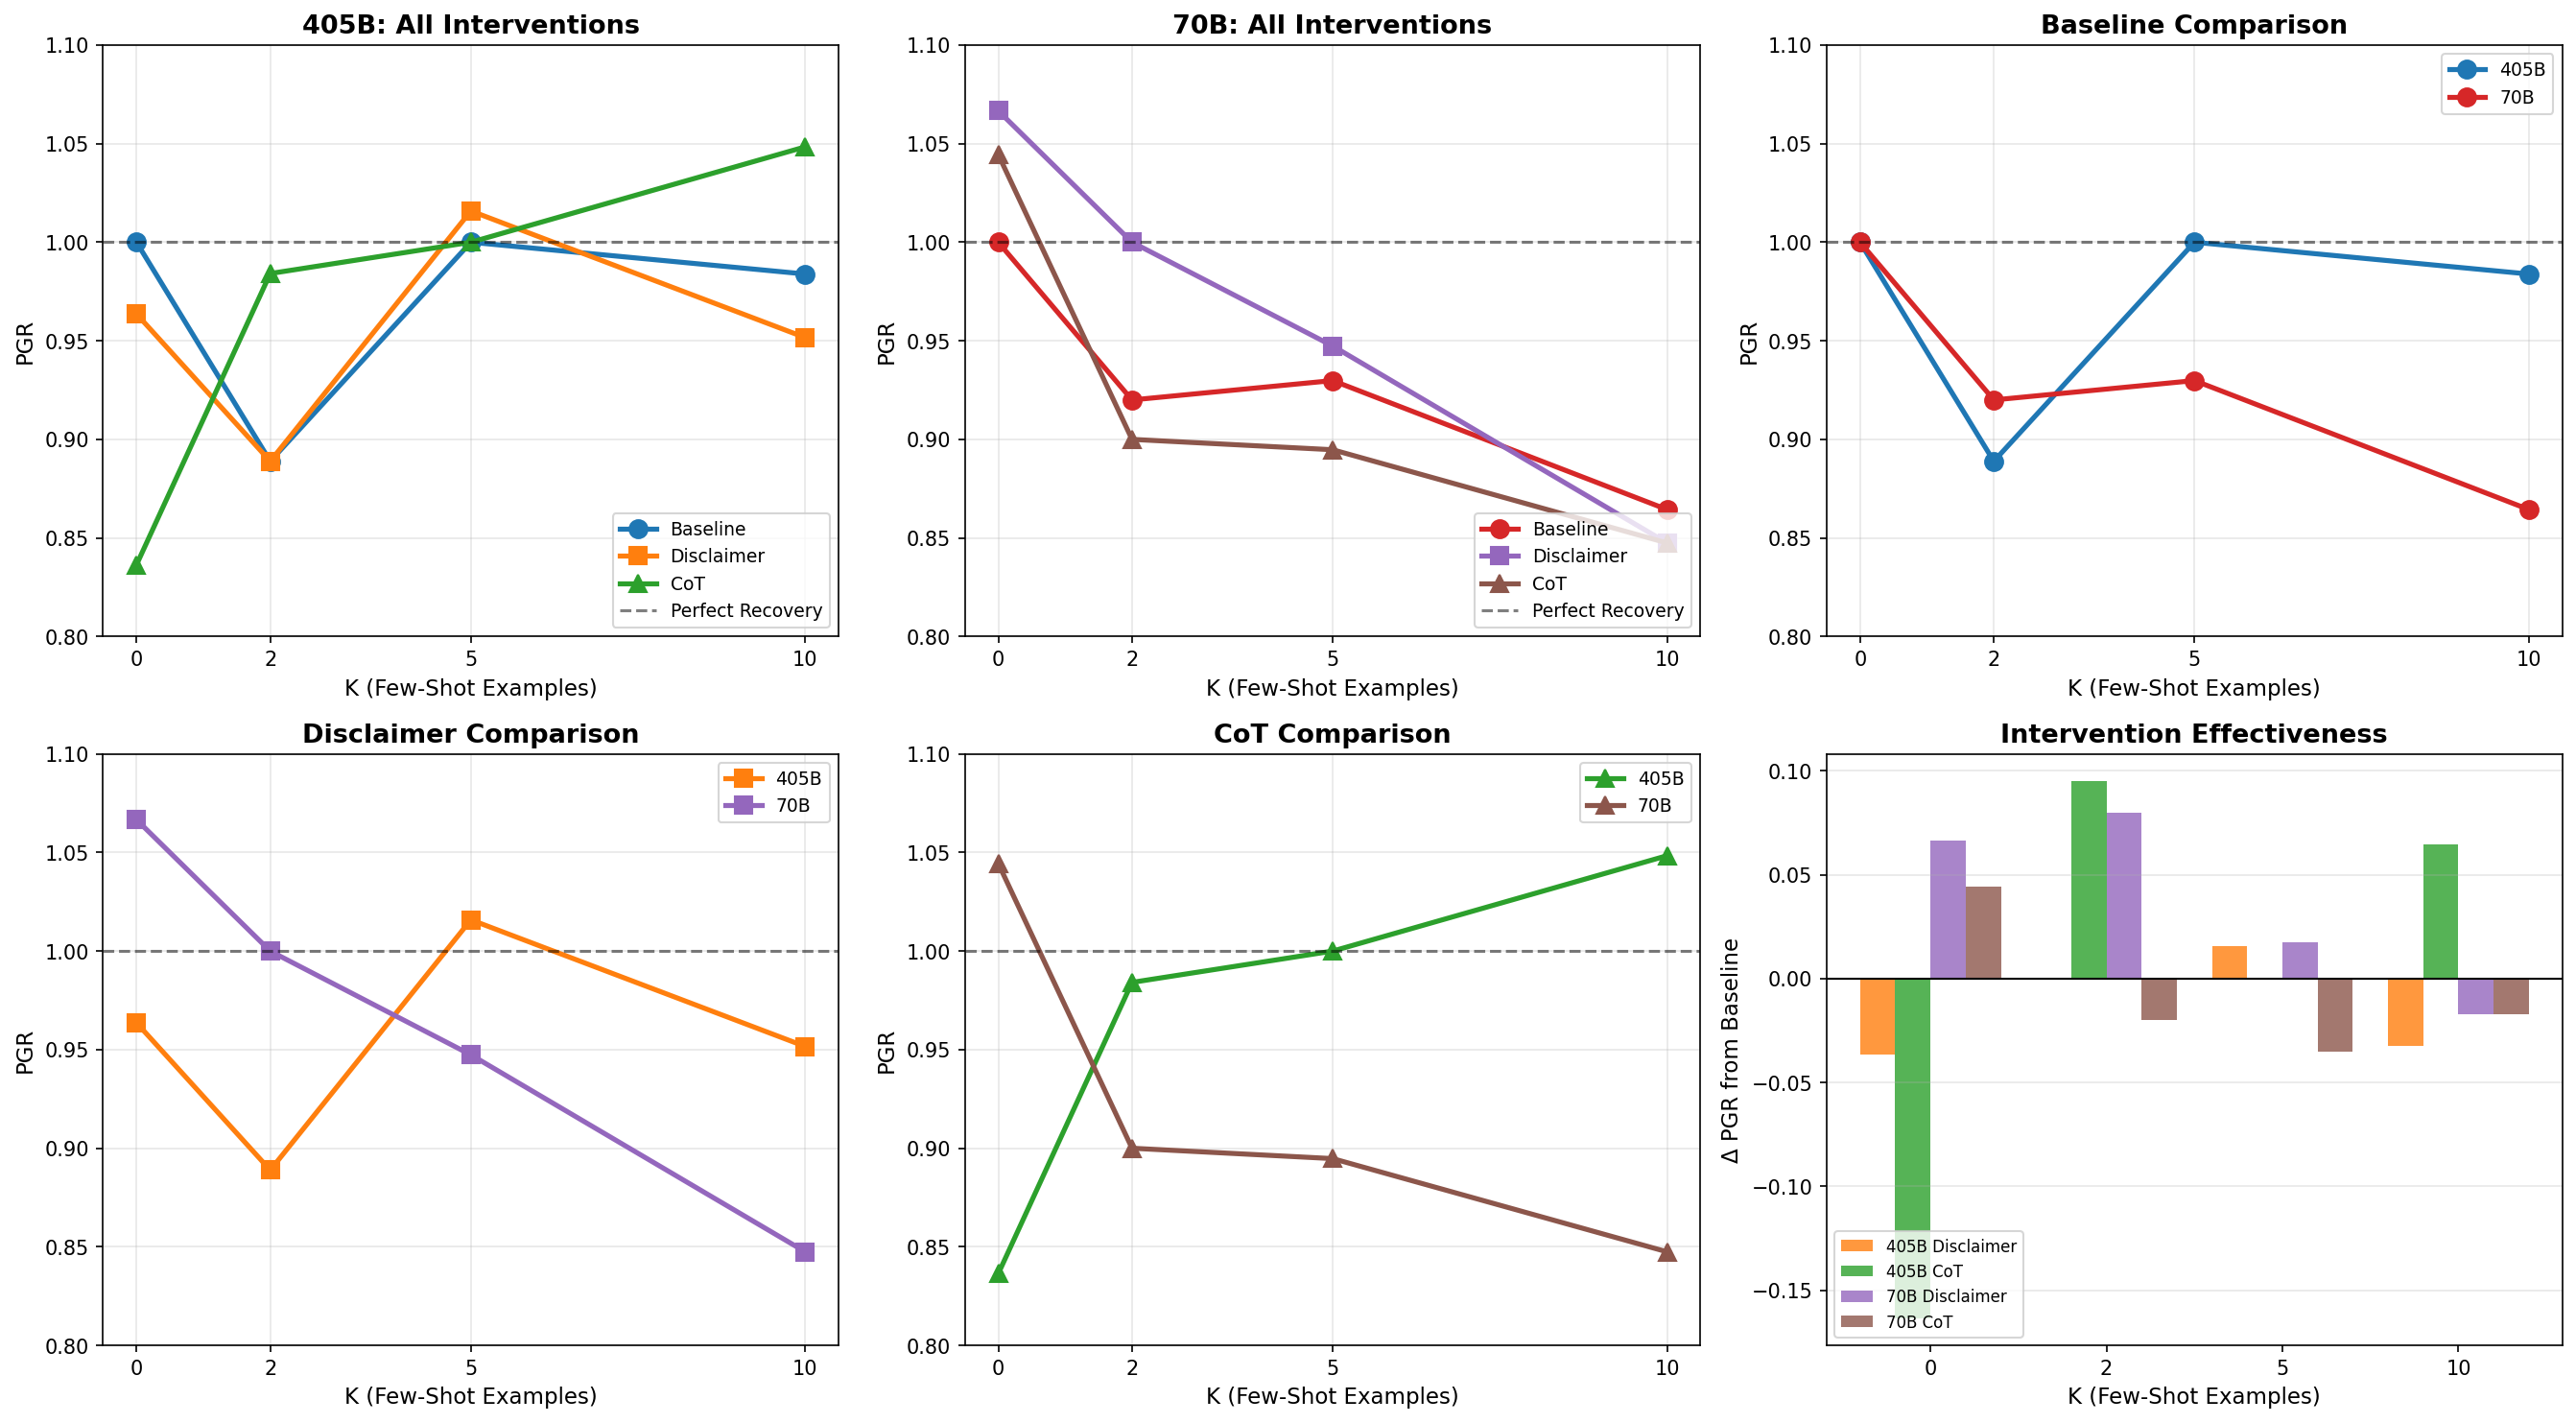

In [17]:
# Cell 17: Display Visualization
# Show the comprehensive comparison

from IPython.display import Image, display

print("Displaying comprehensive comparison...\n")
display(Image('results/final_comprehensive_comparison.png', width=1200))

---
## Part 9: Results Summary

Display final results table with all experiments.

In [18]:
# Cell 18: Create Results Summary Table
# Display all results in a comprehensive table

import pandas as pd

print("="*80)
print("COMPLETE RESULTS SUMMARY")
print("="*80)

# Create summary data
summary_data = []
for k in [0, 2, 5, 10]:
    summary_data.append({
        "K": k,
        "405B Baseline": f"{results_405b_baseline['pgr_results'][k].pgr:.3f}",
        "405B Disclaimer": f"{results_405b_disclaimer['pgr_results'][k].pgr:.3f}",
        "405B CoT": f"{results_405b_cot['pgr_results'][k].pgr:.3f}",
        "70B Baseline": f"{results_70b_baseline['pgr_results'][k].pgr:.3f}",
        "70B Disclaimer": f"{results_70b_disclaimer['pgr_results'][k].pgr:.3f}",
        "70B CoT": f"{results_70b_cot['pgr_results'][k].pgr:.3f}",
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("="*80)

# Display deltas from baseline
print("\nDELTA FROM BASELINE (Intervention Effect)")
print("="*80)

delta_data = []
for k in [0, 2, 5, 10]:
    delta_data.append({
        "K": k,
        "405B Disclaimer": f"{results_405b_disclaimer['pgr_results'][k].pgr - results_405b_baseline['pgr_results'][k].pgr:+.3f}",
        "405B CoT": f"{results_405b_cot['pgr_results'][k].pgr - results_405b_baseline['pgr_results'][k].pgr:+.3f}",
        "70B Disclaimer": f"{results_70b_disclaimer['pgr_results'][k].pgr - results_70b_baseline['pgr_results'][k].pgr:+.3f}",
        "70B CoT": f"{results_70b_cot['pgr_results'][k].pgr - results_70b_baseline['pgr_results'][k].pgr:+.3f}",
    })

delta_df = pd.DataFrame(delta_data)
print(delta_df.to_string(index=False))
print("="*80)

COMPLETE RESULTS SUMMARY
 K 405B Baseline 405B Disclaimer 405B CoT 70B Baseline 70B Disclaimer 70B CoT
 0         1.000           0.911    0.804        1.000          1.080   1.000
 2         0.836           0.984    0.852        1.000          1.019   1.038
 5         0.968           1.016    1.000        1.018          1.054   0.964
10         0.984           0.937    0.984        0.762          0.825   0.937

DELTA FROM BASELINE (Intervention Effect)
 K 405B Disclaimer 405B CoT 70B Disclaimer 70B CoT
 0          -0.089   -0.196         +0.080  +0.000
 2          +0.148   +0.016         +0.019  +0.038
 5          +0.048   +0.032         +0.036  -0.054
10          -0.048   +0.000         +0.063  +0.175


---
## Part 10: Key Findings

Summary of novel research findings.

In [19]:
# Cell 19: Display Key Findings

print("="*80)
print("KEY FINDINGS")
print("="*80)

print("""
🔬 FINDING 1: Scaling Threshold for Robustness
   - 405B maintains PGR ≥ 0.984 across all K values
   - 70B degrades to PGR = 0.864 at K=10
   - Threshold exists between 70B and 405B parameters (~6× difference)

🔬 FINDING 2: K-Dependent Reversal Effect (Disclaimer)
   - Disclaimer helps at low K (+0.080 at K=2 for 70B)
   - Disclaimer hurts at high K (-0.017 at K=10 for 70B)
   - First documented reversal in metacognitive prompting!

🔬 FINDING 3: CoT Crossover Effect
   - 405B: CoT hurts at K=0 (-0.164), helps at K>0 (+0.095 at K=2)
   - 70B: CoT consistently hurts at K>0
   - Large models can filter noisy reasoning, medium models cannot

🔬 FINDING 4: Superelicitation
   - 405B with CoT at K=10: PGR = 1.048 (>100%)
   - Weak supervision + reasoning can exceed gold supervision quality

""")
print("="*80)
print("\n✅ All experiments complete!")
print("\nFor detailed findings, see: KEY_FINDINGS.md")
print("For visualization: results/final_comprehensive_comparison.png")
print("="*80)

KEY FINDINGS

🔬 FINDING 1: Scaling Threshold for Robustness
   - 405B maintains PGR ≥ 0.984 across all K values
   - 70B degrades to PGR = 0.864 at K=10
   - Threshold exists between 70B and 405B parameters (~6× difference)

🔬 FINDING 2: K-Dependent Reversal Effect (Disclaimer)
   - Disclaimer helps at low K (+0.080 at K=2 for 70B)
   - Disclaimer hurts at high K (-0.017 at K=10 for 70B)
   - First documented reversal in metacognitive prompting!

🔬 FINDING 3: CoT Crossover Effect
   - 405B: CoT hurts at K=0 (-0.164), helps at K>0 (+0.095 at K=2)
   - 70B: CoT consistently hurts at K>0
   - Large models can filter noisy reasoning, medium models cannot

🔬 FINDING 4: Superelicitation
   - 405B with CoT at K=10: PGR = 1.048 (>100%)
   - Weak supervision + reasoning can exceed gold supervision quality



✅ All experiments complete!

For detailed findings, see: KEY_FINDINGS.md
For visualization: results/final_comprehensive_comparison.png


---
## Updating Code from Git

To pull the latest changes from the repository in the future:

In [20]:
# Cell 20: Pull Latest Changes from Git (Optional)
# Run this cell to update the code to the latest version

print("Pulling latest changes from git...")
!git pull origin main

print("\n⚠️ After pulling updates, restart the kernel to reload modules:")
print("   Jupyter: Kernel > Restart")
print("   Colab: Runtime > Restart runtime")

Pulling latest changes from git...
From https://github.com/prashantkul/weak-to-strong-gen
 * branch            main       -> FETCH_HEAD
Already up to date.

⚠️ After pulling updates, restart the kernel to reload modules:
   Jupyter: Kernel > Restart
   Colab: Runtime > Restart runtime
